In [98]:
#Imports
from datetime import time
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import sklearn as skl
from copy import deepcopy
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomTreesEmbedding, RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
import json

In [99]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
raw_train = pd.read_csv("Data/train.csv")
raw_test = pd.read_csv("Data/test.csv")

raw_train.shape

(510, 22)

In [100]:
# this data reformat function is shared by all models and executed beforehand
# I assume we know the test set in advance
def shared_reformat(df):
    df = deepcopy(df)
    
    # create special targets (only on train set)
    if "max_price" in list(df):
        df["delta_abs"] = df["max_price"] - df["min_price"] 
        df["delta_rel"] = np.log(df["max_price"] / df["min_price"] )
    
    # deal with missing data
    #df.pixels_y = df.pixels_y.fillna(0)
    df.detachable_keyboard.fillna(0, inplace = True)  # only four cases. Assume none
    df.pixels_x.fillna(1920, inplace = True)   # only 2 cases, replace by most common value
    df.pixels_y.fillna(1080, inplace = True)   # only 2 cases, replace by most common value
    df.loc[df.screen_surface.isna(), "screen_surface"] = 'Glossy'       # 12 cases, large majority is Glossy,
    df.loc[df.screen_surface.isna() & df.pixels_x == 1920, "screen_surface"] = 'Matte'  # except here
    df.sort_values(by=['name'])
    df.cpu_details.fillna(method='bfill', inplace=True)  # take previous value, they are often similar
    df.gpu.fillna(method='bfill', inplace=True)  # take previous value, they are often similar
    df.weight.fillna(method='bfill', inplace=True)
    df.loc[df.os.isna() & df.brand == "Apple", "os"] = 'macOS'  # 1 case
    df.loc[df.os_details.isna() & df.brand == "Apple", "os_details"] = "macOS Mojave"  # 1 case, most common
    df.loc[df.os.isna() & df.brand == "Dell", "os"] = 'Windows'  # 1 case
    df.loc[df.os_details.isna() & df.brand == "Dell", "os_details"] = "Windows 10 Home"  # 1 case, most common
    

    # create new features
    df["cpu_brand"] = df.cpu.str.split(n=1).str[0]
    df["cpu_type"] = df.cpu.str.split(n=1).str[1]
    df["gpu_brand"] = df.gpu.str.split(n=1).str[0]
    df["gpu_series"] = df.gpu.str.split(n=2).str[1]
    df["os_type"] = df.os_details.str.split(n=1).str[1]
    df["os_nr"] = df.os_details.str.split(n=2).str[2]
    df["resolution"] = df.pixels_y / df.screen_size
    df["gimmick"] = df.detachable_keyboard + 5 * df.discrete_gpu + 3* df.touchscreen
    def get_speed(sentence):
        try:
            sentence = sentence.split()
            index = sentence.index('GHz')
            return pow(float(sentence[index-1]),2)
        except:
            return pow(2.4, 2)
    df["speed"] = df.cpu_details.apply(get_speed)
    def has_word(sentence, word):
        try:
            return word in sentence
        except:
            return False
    df["Dual-Core"] = df.cpu_details.apply(has_word, word="Dual-Core")
    df["Quad-Core"] = df.cpu_details.apply(has_word, word="Quad-Core")
    df["Hexa-Core"] = df.cpu_details.apply(has_word, word="Hexa-Core")
    df["Hyper-Threading"] = df.cpu_details.apply(has_word, word="Hyper-Threading")
    
    
    # correct a few mistakes in new features
    map_gpu_series = {"GeFoce":"GeForce", "RadeonÂ": "Radeon"}
    df.gpu_series = df.gpu_series.replace(map_gpu_series) 
    map_screen_surface = {"glossy":"Glossy", "matte":"Matte"}
    df.screen_surface = df.screen_surface.replace(map_screen_surface)  

    
    # make sure all values in categorical variables are strings
    cat_col = df.select_dtypes(include=['object']).columns
    df[cat_col] = df[cat_col].astype(str)
    
    # cleanup test set
    df.pixels_y = df.pixels_y.astype('int64')
    
    # shuffle the database
    df.sample(frac=1)
    return df


In [101]:
df_train = shared_reformat(raw_train)
df_test = shared_reformat(raw_test)

df_test.shape

C:\ProgramData\Anaconda3\envs\ComputerPriceRange\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


(222, 33)

In [102]:
print(df_train.columns)
print(df_test.columns)

Index(['id', 'name', 'brand', 'base_name', 'screen_size', 'pixels_x',
       'pixels_y', 'screen_surface', 'touchscreen', 'cpu', 'cpu_details',
       'detachable_keyboard', 'discrete_gpu', 'gpu', 'os', 'os_details', 'ram',
       'ssd', 'storage', 'weight', 'min_price', 'max_price', 'delta_abs',
       'delta_rel', 'cpu_brand', 'cpu_type', 'gpu_brand', 'gpu_series',
       'os_type', 'os_nr', 'resolution', 'gimmick', 'speed', 'Dual-Core',
       'Quad-Core', 'Hexa-Core', 'Hyper-Threading'],
      dtype='object')
Index(['id', 'name', 'brand', 'base_name', 'screen_size', 'pixels_x',
       'pixels_y', 'screen_surface', 'touchscreen', 'cpu', 'cpu_details',
       'detachable_keyboard', 'discrete_gpu', 'gpu', 'os', 'os_details', 'ram',
       'ssd', 'storage', 'weight', 'cpu_brand', 'cpu_type', 'gpu_brand',
       'gpu_series', 'os_type', 'os_nr', 'resolution', 'gimmick', 'speed',
       'Dual-Core', 'Quad-Core', 'Hexa-Core', 'Hyper-Threading'],
      dtype='object')


In [103]:
targets = ["max_price", "delta_abs", "delta_rel", "min_price"]
# initialize dictionaries. Keys are the model names
model_dict = {}
reformat_dict = {}
categories_dict = {}
log_dict = {}

In [104]:
# prepares the regressor and X values for a model
def prepare_model(model, df, target, log, verbose=True):
    vprint = print if verbose else lambda *a, **k: None
    df_pp = reformat_dict[model](df)
    X = df_pp.drop(targets, axis=1)
    categories = categories_dict[model]
    preprocessor = create_preprocessor(X, categories)
    input_shape = Pipeline([('tp', preprocessor)]).fit_transform(X).shape[1]
    vprint("nr of features=", input_shape)
    regressor = model_dict[model](preprocessor, input_shape)
    if log: regressor = TransformedTargetRegressor(regressor=regressor, func=np.log, inverse_func=np.exp)
    return X, regressor

In [105]:
# computes all levels for all categorical variables
# that a give model uses. Takes both training and
# test set into account (we know the test set)

def get_categories(df_train, df_test, reformater):
    # compute levels categorical variables for Huber
    train_df = reformater(df_train)
    train_df = train_df.drop(columns=targets)
    test_df = reformater(df_test)
    categorical_features = test_df.select_dtypes(include=['object']).columns
    df_full = pd.concat([train_df,test_df], join='outer', axis=0)
    categories = []
    for col in categorical_features:
        categories.append(df_full[col].unique())
    return categories

In [106]:
## RANDOM FOREST REGRESSOR ##
def reformat_rfr(df):
    df = deepcopy(df)
    
    # transform values of some nominal variables
    df.screen_size = df.screen_size.pow(2)  #square the values
    df.ram = df.ram.pow(2)  #square the values
    df.weight = np.maximum(0,np.log(df.weight)) 
    
    # drop columns
    drop_cols=["id", "name", "gpu_series", "pixels_x", "screen_surface", "os", "os_details", "cpu_brand",
              "detachable_keyboard", "touchscreen", "os_nr", "screen_size", "cpu_details", "brand",
              "gpu_brand", "os_type", "storage"]
    drop_cols=["id", "name", "base_name", "screen_size", "weight", "detachable_keyboard", "gpu_series",
              "ssd", "pixels_x", "cpu_details", "os_details", "cpu_brand", "cpu", "os"]
    df = df.drop(columns=drop_cols)
    
    # replace rare categorical levels by "other": doesn't seem to help
    #cat_col = df.select_dtypes(include=['object']).columns
    #for col in cat_col:
    #    val_counts = df[col].value_counts(normalize=True).cumsum()
    #    val_counts = val_counts.where(val_counts < .99)
    #    keep_vals = list(val_counts.dropna().index.values)
    #    df.loc[~df[col].isin(keep_vals), col] = "other"

    return df

reformat_dict["rfr"] = reformat_rfr
categories_dict["rfr"] =  get_categories(df_train, df_test, reformat_rfr)
log_dict["rfr"] = True

def pipe_rfr(preprocessor, input_shape):
    pipeline= Pipeline([
                    (('preprocessor', preprocessor)),
                     ('rfr', RandomForestRegressor(criterion="mse", max_features = .2, n_jobs=-1,
                                                   min_samples_leaf=1, max_depth=20, n_estimators=500))
     ])
    return pipeline
model_dict["rfr"] = pipe_rfr

In [107]:
# this preprocessor is the same for all models, but doesn't have to be
def create_preprocessor(df_pp, categories):
    #global categories
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
        ])
    categorical_transformer = Pipeline(steps=[
        ('imputer',SimpleImputer(strategy='constant', fill_value='missing')),
        #('ordinal', OrdinalEncoder(categories=categories)),
        #('scaler', StandardScaler())
        ('onehot', OneHotEncoder(categories=categories, handle_unknown="ignore")),   
        ])

    numeric_features = df_pp.select_dtypes(include=['int64', 'float64', 'boolean']).columns
    categorical_features = df_pp.select_dtypes(include=['object']).columns
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    return preprocessor

In [108]:
# permutation variable importance
def var_importance(pipe, X, Y, scoring=None):
    perm_imp = permutation_importance(pipe, X, Y, scoring=scoring, n_repeats=10, n_jobs=None, random_state=None)
    sorted_idx = perm_imp.importances_mean.argsort()

    fig, ax = plt.subplots()
    ax.boxplot(perm_imp.importances[sorted_idx].T,
               vert=False, labels=X.columns[sorted_idx])
    ax.set_title("Permutation Importances (test set)")
    fig.tight_layout()
    plt.show()


In [109]:
# With this function, models are tested in 10-fold cross_validation and
# a permutation variance analysis is performed
def test_model(model, df, target = "max_price", log=True, nr_folds=10):
    Y = df[target]
    X, regressor = prepare_model(model, df, target, log)
    scores = cross_validate(regressor, X, Y, scoring=['neg_mean_absolute_error'], cv=nr_folds)
    print("gemiddeld: {}, details: {}".format(-np.mean(scores['test_neg_mean_absolute_error']), -scores['test_neg_mean_absolute_error']))
    regressor.fit(X, Y)
    var_importance(regressor, X, Y)

nr of features= 187
gemiddeld: 144.10986469361234, details: [104.78378255 213.61273473 129.44513904 138.38498051 150.58726798
 140.51069636 126.49274973 137.63047753 194.5247755  105.12604301]
nr of features= 187
gemiddeld: 138.79742649126666, details: [102.87129166 209.4644752  105.69997561 129.10413088 133.91683483
 128.14942018 139.20414514 128.84032255 194.97537901 115.74828986]


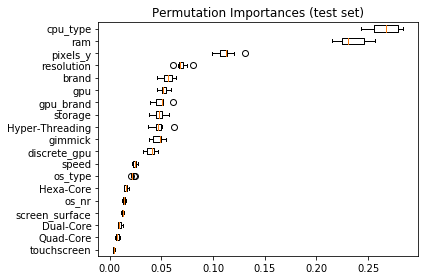

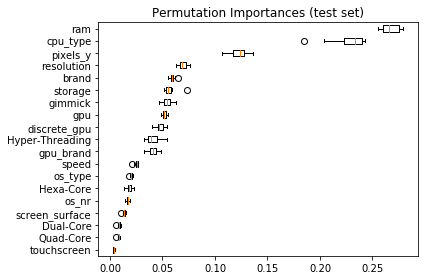

In [110]:
test_model("rfr", df_train, target="max_price", log=True)
test_model("rfr", df_train, target="min_price", log=True)

In [ ]:
def seppe_error(Y1_true, Y1_pred, Y2_true, Y2_pred):
    return (mean_absolute_error(Y1_true, Y1_pred) + mean_absolute_error(Y2_true, Y2_pred)) / 2

In [ ]:
## RANDOM FOREST REGRESSOR ##
def runRFR(X,y):
    
    rfr = RandomForestRegressor(X,y)
    
    params = dict(
        n_estimators=[100, 300, 500, 1000],
        max_features = [.1, .2, .5, "auto", "log2"],
        min_samples_leaf = [1, 5, 10]
    )
    
    print("Parameters used for tuning:")
    for key in params:
        print("{:20}: {}".format(key, params[key]))
        print("")
  
 

    start_time = time.time()
    print("Start hyper parameters tuning...")
    algorithm = GridSearchCV(rfr, params, scoring=make_scorer(seppe_error, greater_is_better=False), cv=3, n_jobs=-1)
    #algorithm = RandomizedSearchCV(isolation_forest, param_distributions=params, scoring=scorer, cv=5, n_iter=20, n_jobs=-1)
    algorithm.fit(X,y)
    seconds = time.time() - start_time
    minutes, seconds = divmod(seconds, 60)
    print("Hyper parameters tuning done in {:.2f} minutes and {:.2f} secondes".format(minutes, seconds))

    print("{}:\n{}".format("Best parameters found", json.dumps(algorithm.best_params_, indent=2)))
    
    return algorithm.predict(X)